In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import ifft, fft, fftfreq, fftshift, ifft2, fft2
from scipy import signal
from scipy.io import wavfile
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from datetime import datetime, timedelta
from audio_function import plot1, plot1_f, mean_data_sep, mean_autocorr_signal, corr_t, corr_f, count_time, cos_sim, cr_arr_t, norm_max, load_mat, first_second_part, filt_freq, variation_data, t_arr_for_corr_t, df, audio_data49_3, audio_data49_2, audio_data16_3, audio_data16_2, sample_rate, audio_data49_1

Данные загружены


In [3]:
# Создание массивов, используемых в обработке
t_f_arr_1 = cr_arr_t(49)
t_f_arr_2 = cr_arr_t(47)
t_f_arr_3 = cr_arr_t(58)

audio_data49_3_1 = audio_data49_3[t_f_arr_1[0]]
audio_data49_3_2 = audio_data49_3[t_f_arr_2[0]]
audio_data49_3_3 = audio_data49_3[t_f_arr_3[0]]

audio_data49_2_1 = audio_data49_2[t_f_arr_1[0]]
audio_data49_2_2 = audio_data49_2[t_f_arr_2[0]]
audio_data49_2_3 = audio_data49_3[t_f_arr_3[0]]

audio_data49_1_1 = audio_data49_1[t_f_arr_1[0]]
audio_data49_1_2 = audio_data49_1[t_f_arr_2[0]]
audio_data49_1_3 = audio_data49_1[t_f_arr_3[0]]

audio_data16_1_1 = audio_data16_2[t_f_arr_1[0]]
audio_data16_1_2 = audio_data16_2[t_f_arr_2[0]]
audio_data16_1_3 = audio_data16_2[t_f_arr_3[0]]

min_len_1 = min(len(audio_data49_3_1),len(audio_data49_2_1))

1
50
30


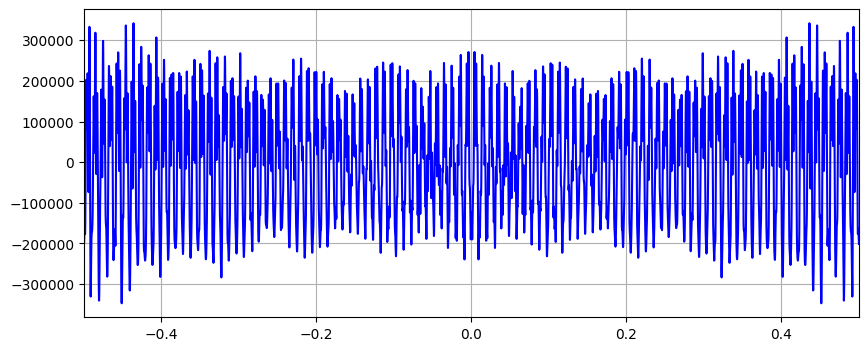

In [5]:
cross_corr_1 = corr_t(audio_data49_1_1, audio_data49_3_1, 0, 600)
t_cross1 = t_arr_for_corr_t(cross_corr_1)
plt.figure(figsize=(10,4))
plt.plot(t_cross1, cross_corr_1, color='blue')
plt.xlim(-0.5, 0.5)
plt.grid(True)
plt.show()

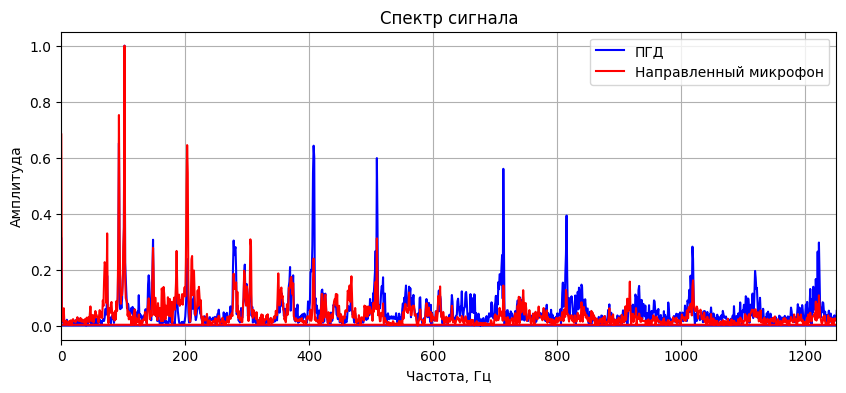

In [ ]:
plt.figure(figsize=(10,4))
spectrum_1 = np.abs(fft(audio_data49_1_1))
spectrum_2 = np.abs(fft(audio_data49_3_1))
spectrum_1 = spectrum_1/np.max(spectrum_1)
spectrum_2 = spectrum_2/np.max(spectrum_2)
plt.plot(t_f_arr_1[2], spectrum_1, color='blue')
plt.plot(t_f_arr_1[2], spectrum_2, color='red')
plt.title('Спектр сигнала')
plt.xlabel('Частота, Гц')
plt.ylabel('Амплитуда, нормированная')
plt.legend(['ПГД', 'Направленный микрофон'])
plt.xlim(0, 1250)
plt.grid(True)
plt.show()

In [ ]:
cross_corr_2 = corr_t(audio_data49_2_2, audio_data49_3_2, 0, 250)
t_cross_2 = t_arr_for_corr_t(cross_corr_2)
plt.figure(figsize=(10,4))
plt.plot(t_cross_2 , cross_corr_2, color='blue')
plt.xlim(-0.1, 0.1)
plt.grid(True)
plt.show()

In [ ]:
cross_corr_3 = corr_t(audio_data49_2_3, audio_data49_3_3, 15, 250)
t_cross_3 = t_arr_for_corr_t(cross_corr_3)
plt.figure(figsize=(10,4))
plt.plot(t_cross_3 , cross_corr_3, color='blue')

plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


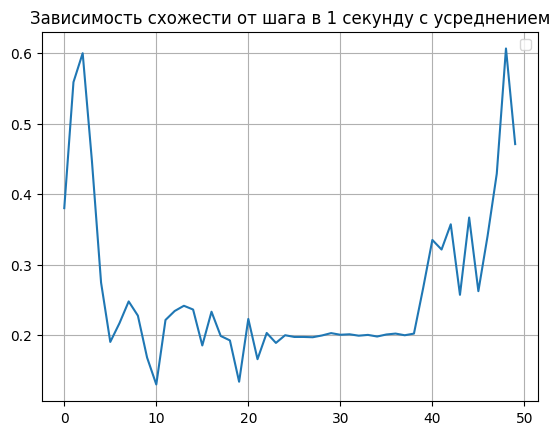

In [15]:
S_N_arr_2 = []
audio_data49_3_1_mean = mean_data_sep(audio_data49_3_1, 0.1)
array_audiodata_2 = []
for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]

    audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.1)
    array_audiodata_2.append(audiodata2_sec_mean)
    
    a = cos_sim(audio_data49_3_1_mean, audiodata2_sec_mean, 60, 850)
    S_N_arr_2.append(a)
    
n2 = np.arange(int(t_f_arr_2[3]))

plt.plot(n2, S_N_arr_2)
plt.title('Зависимость схожести от шага в 1 секунду с усреднением')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
a = np.array([0, 1, 2, 3, 4])
b = np.array([0, 0, 0, 0, 1])

norm1 = np.sum((np.abs(a))**2)
norm2 = np.sum((np.abs(b))**2)

data12 = np.sum(a*b)
data_norm12 = np.sqrt(norm1) * np.sqrt(norm2)
SN = data12/data_norm12
print(SN)

In [ ]:
audio_data49_3_1_mean = mean_data_sep(audio_data49_3_1, 0.1)
f = fftfreq(int(len(audio_data49_3_1_mean)), 1 / sample_rate)
plot1_f(f, audio_data49_3_1_mean, 'Спектр после', 250, 'f, Гц')

In [ ]:
audio_data49_3_1_mean = mean_data_sep(audio_data49_3_1, 0.1)
data1 = filt_freq(audio_data49_3_1_mean, 60, 250)

f = fftfreq(int(len(data1 )), 1 / sample_rate)
plot1_f(f, data1, 'Спектр после', 300, 'f, Гц')

i = 45
i_beg = int(i*44100)
i_fin = int((i+1)*44100)
audiodata2_sec = audio_data49_3_2[i_beg:i_fin]

audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.1)

data2  = filt_freq(audiodata2_sec_mean , 60, 250)

plot1_f(f, data2 , 'Спектр после', 300, 'f, Гц')

# array_audiodata_2.append(audiodata2_sec_mean)
    
a = cos_sim(audio_data49_3_1_mean, audiodata2_sec_mean, 20, 250)
# S_N_arr_2.append(a)
    
data12 = np.sum(data1*data2)
norm1 = np.sum((np.abs(data1))**2)
norm2 = np.sum((np.abs(data2))**2)
data_norm12 = np.sqrt(norm1) * np.sqrt(norm2)
SN = data12/data_norm12

print(data12, norm1, norm2, a, SN)

In [ ]:
data1 = filt_freq(audio_data49_3_1_mean, 60, 250)
plot1_f(f, data1, 'Спектр после', 300, 'f, Гц')

i = 32
i_beg = int(i*44100)
i_fin = int((i+1)*44100)
audiodata2_sec = audio_data49_3_2[i_beg:i_fin]

audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.1)
data2  = filt_freq(audiodata2_sec_mean , 60, 250)
plot1_f(f, data2, 'Спектр после', 300, 'f, Гц')

# array_audiodata_2.append(audiodata2_sec_mean)
    
a = cos_sim(data1, data2, 60, 250)
# S_N_arr_2.append(a)
    
data12 = np.sum(data1*data2)
norm1 = np.sum((np.abs(data1))**2)
norm2 = np.sum((np.abs(data2))**2)
data_norm12 = np.sqrt(norm1) * np.sqrt(norm2)
SN = data12/data_norm12

print(data12, norm1, norm2, a, SN)

In [ ]:
data1 = filt_freq(audio_data49_3_1_mean, 60, 250)
plot1_f(f, data1, 'Спектр после', 300, 'f, Гц')

i = 32
i_beg = int(i*44100)
i_fin = int((i+1)*44100)
audiodata2_sec = audio_data49_3_2[i_beg:i_fin]

audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.1)
data2  = filt_freq(audiodata2_sec_mean, 60, 250)
plot1_f(f, data2, 'Спектр после', 300, 'f, Гц')

# array_audiodata_2.append(audiodata2_sec_mean)
    
a = cos_sim(audio_data49_3_1_mean, audiodata2_sec_mean, 60, 250)
# S_N_arr_2.append(a)
    
data12 = np.sum(data1*data2)
norm1 = np.sum((np.abs(data1))**2)
norm2 = np.sum((np.abs(data2))**2)
print(data12, norm1, norm2, a)

In [ ]:
max_autocorr_signal = []

for i in range (0, int(t_f_arr_2[3])):
    i_beg = int(i*44100)
    i_fin = int((i+1)*44100)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
    audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.2)
    audio_data49_3_1_mean = mean_data_sep(audio_data49_3_1, 0.2)
    
    b = (mean_autocorr_signal(audio_data49_3_1_mean, audiodata2_sec_mean, 0, 250))
    max_autocorr_signal.append(b)

l = len(max_autocorr_signal)
N_max = np.arange(l)
plt.plot(N_max, max_autocorr_signal)
plt.grid(True)
plt.title('Зависимоость функции (*) от N секунды')
plt.legend()
plt.show()

In [ ]:
min_spectrum = []
for i in range (0, int(t_f_arr_2[3])):
    
    i_beg = int(i*sample_rate)
    i_fin = int((i+1)*sample_rate)
    audiodata2_sec = audio_data49_3_2[i_beg:i_fin]

    audiodata2_sec_mean = mean_data_sep(audiodata2_sec, 0.1)
    # audio_data49_3_1_mean = mean_data_sep(audio_data49_3_1, 0.1)

    c = np.mean(audiodata2_sec_mean)**2
    min_spectrum.append(c)

min_spectrum = np.array(min_spectrum)
min_spectrum = (min_spectrum)*(min_spectrum)
l = len(min_spectrum)
N_max = np.arange(l)
plt.plot(N_max, norm_max(min_spectrum))
plt.grid(True)
plt.title('Зависимость функции усреднения спектра от N секунды')
plt.legend()
plt.show()

In [ ]:
spectr_port_1 = fft(audio_data49_3_1)
spectr_port = filt_freq(spectr_port_1, 60, 250)
f = fftfreq(int(len(spectr_port_1)), 1 / sample_rate)
plot1_f(f, spectr_port, 'Спектр после', 250, 'f, Гц')

In [ ]:
# Графики исследований
plt.plot(t_f_arr_1[1], audio_data49_3_1, color='brown', label='Small')
plt.show()

plt.plot(t_f_arr_1[1], audio_data49_2_1, color='blue', label='Small')
plt.show()

In [ ]:
# S_N_arr_autocorr = []
# for i in range (0, int(t_f_arr_2[3])):
#     i_beg = int(i*sample_rate)
#     i_fin = int((i+1)*sample_rate)
#     audiodata2_sec = audio_data49_3_2[i_beg:i_fin]
#     audiodata2_sec = mean_data_sep(audiodata2_sec, 0.1)
#     audio_data49_3_1_m = mean_data_sep(audio_data49_3_1, 0.1)
#     a = cos_sim(audio_data49_3_1_m, audiodata2_sec, 50, 500)
#     S_N_arr_autocorr.append(a)

corr_t_2_micr = corr_t(audio_data49_3_2, audio_data49_2_2, 0, 1000)
t_c = t_arr_for_corr_t(corr_t_2_micr)
plt.plot(t_c, (corr_t_2_micr))
plt.grid(True)
plt.xlim(-2, 2)
plt.title('Временная корреляция с 2 микрофонов, при пролете около них')
plt.legend()
plt.show()

In [ ]:
corr_t_2_micr = corr_t(audio_data49_3_1, audio_data49_2_1, 250)
t_c = t_arr_for_corr_t(corr_t_2_micr)
plt.plot(t_c, (corr_t_2_micr))
plt.grid(True)
plt.xlim(-0.02, 0.02)
plt.title('Временная корреляция с 2 микрофонов, при пролете около них')
plt.legend()
plt.show

In [ ]:
data1_0db = load_mat('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/Matlab_Files/2023.03.31-11.59.31_channel_0.mat')
data1_70db = load_mat('/Users/bogda/Desktop/Acoustics/Scientific/Исходные данные/Matlab_Files/2023.03.31-11.52.03_channel_0.mat')
Fs = 48000
data_first, data_second = first_second_part(data1_0db)
mn = min(len(data_first), len(data_second))
t = np.arange(int(mn))/Fs
t_central = t - mn/Fs/2
f1 = fftfreq(mn, 1 / Fs)
f = fftfreq(min(len(data1_0db), len(data1_70db)), 1 / Fs)
c_t_parts = corr_t(data_first, data_second, 0, 10000)
c_f_parts = corr_f(data_first, data_second, 0, 10000)
autocorr_t = corr_t(data_first, data_first, 0, 10000)

In [ ]:
plot1(t_central, autocorr_t, "Автокорреляция")
plot1(t_central, (c_t_parts), "Корреляция 1 и 2 половинки")

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(fft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр автокорреляции по t 1 половинки дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(f1, np.abs(fft(autocorr_t)), color='blue')
plt.ylabel('Амплитуда, у.е.')
plt.title('Спектр корреляции по t 1 и 2 половинок дрона')
plt.grid(True)
plt.xlim(-2000, 2000)
plt.show()